## Remove old files from previous rus

In [1]:
def clean_files():
    os.system("del _*")
    os.system("del WT*")
    os.system("del Aver*")
    os.system("del mutation*.csv")
    os.system("del s_*")
    os.system("del repa_*")
    os.system("del Pdb*")
    os.system("del *.pgn")
    os.system("del system*.pdb")
    os.system("del system*.psf")
    os.system("del Raw*")
    os.system("del epa*")
    os.system("del eq*")
    os.system("del Dif*")

    os.system("del cg-repa*")
    os.system("del AA-repa*")
    os.system("del temp*")
    os.system("del eq-cg*")

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

$\mathbb P[X > Y]$ <br>
$\mathbb P[X - Y > 0]$ <br>
$\text{We know that, if the variables are gaussian, } \underbrace{X-Y}_Z \sim \mathcal N(\mu_X - \mu_Y,\sigma^2_X + \sigma^2_Y)$ <br>
$\mathbb P[Z > 0] = \mathbb P \left[ {\sqrt{\sigma^2_X + \sigma^2_Y}}\left( \underbrace{\overbrace{N}^{\sim \mathcal N(0,1)} + 
\frac{1}{
    \sqrt{
        \sigma^2_X + \sigma^2_Y
    }
}(\mu_X - \mu_Y) }_{
\sim 
    \mathcal N(
        \frac{1}{\sqrt{\sigma^2_X + \sigma^2_Y}}(\mu_X - \mu_Y)
        ,1)}\right) > 0 \right] = 
\mathbb P \left[ N + \frac{1}{
    \sqrt{
        \sigma^2_X + \sigma^2_Y
    }
}(\mu_X - \mu_Y)  > 0 \right]  = 
\mathbb P \left[ N > \frac{1}{
    \sqrt{
        \sigma^2_X + \sigma^2_Y
    }
}(\mu_Y - \mu_X)  \right] =
1 - \mathbb P \left[ N < \frac{1}{
    \sqrt{
        \sigma^2_X + \sigma^2_Y
    }
}(\mu_Y - \mu_X) \right] =
1 - cdf\left(\frac{1}{
    \sqrt{
        \sigma^2_X + \sigma^2_Y
    }
}(\mu_Y - \mu_X) \right)
$

$\mathbb P[X > Y] = 1 - cdf\left(\frac{1}{
    \sqrt{
        \sigma^2_X + \sigma^2_Y
    }
}(\mu_Y - \mu_X) \right)$

b è maggiore di a?  True
N(mu = 1.00000,var = 0.01000) N(mu = 2.00000,var = 0.25000)


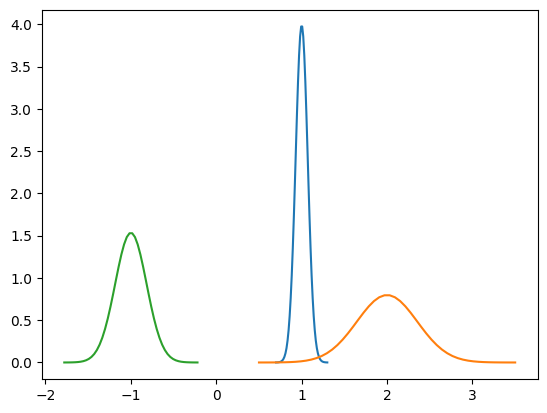

In [4]:
class ConfidenceInterval:
    def __init__(self,mean,std):
        self.mean     = mean
        self.std      = std
        self.treshold = 0.9
    def plot(self,ax = plt):
        x = np.linspace(self.mean - 3 * self.std, self.mean + 3 * self.std)
        y = 1./(2 * np.pi * self.std**2)**(1./2.) * np.exp( - (x - self.mean)**2 / self.std**2 )
        plt.plot(x,y)
    def __gt__(self, other):
        # siano X e Y due variabili aleatorie
        # diciamo che X > Y <===> P[X > Y] > treshold
        mu_diff      = other.mean - self.mean
        sqrt_var_sum = np.sqrt(other.std**2 + self.std**2)
        return (1 - norm.cdf( 1 / sqrt_var_sum * mu_diff )) > self.treshold
    def __repr__(self):
        return "N(mu = %.5f,var = %.5f)" % (self.mean, self.std**2)
    def __sub__(self,other):
        return ConfidenceInterval(self.mean - other.mean, self.std**2 + other.std**2)
a = ConfidenceInterval(1,0.1)
b = ConfidenceInterval(2,0.5)
print("b è maggiore di a? ", b > a )
a.plot(plt)
b.plot(plt)
(a - b).plot()
print(a,b)

True

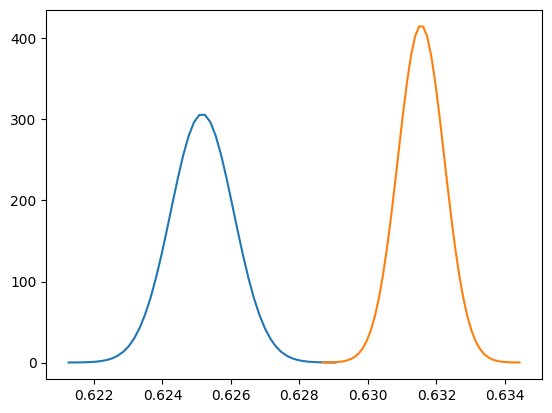

In [5]:
import numpy as np

def bootstrap(X,N):
    D = X[np.random.choice(len(X),size = (N, int(len(X)/2)))]
    return D

def clean_q_value(noisy_signal, adaptive = False, m = 50, p=0.2):
    if adaptive == True:
        m = int(len(noisy_signal)*p)
    
    # *** 29/11/2023 12.50 ***********************************************************************
    normalized_signal = noisy_signal / noisy_signal[0]                      # fisso il massimo a 1
    # *************************************************************************************Luca***
    D = bootstrap(normalized_signal[m:], 20000)
    medie = D.mean(axis = 1)
    return ConfidenceInterval(medie.mean(), np.sqrt(medie.var()))

X = np.load("qvalues.npy")
a = clean_q_value(X,True,p = 0.3)
a.plot()
X = np.load("qvalues(47).npy")
b = clean_q_value(X,True,p = 0.3)
b.plot()
b > a

In [6]:
import os
import pandas as pd
import subprocess
class Protein:
    instances = 0
    
    def __init__(self, filename):
        self.filename = filename
        self.q_value  = None                               # unitialized q value
        # set of available_mutations
    def build_neighbors_on_mutation_lattice(self, threshold): # build the lattices based on the ALA threshold's Gibbs free energy
        # generate config file with possible mutations for the current protein
        os.system("python mutation_generator.py " + self.filename + " " + str(threshold))
        # Protein.instances += 1 ## questo sarebbe da gestire in un altro modo

        # mutate the protein 
        print("Generating  mutated pdbs...")
        os.system("foldx_5 --command=BuildModel --pdb=" + (self.filename) + " --mutant-file=individual_list.txt")
 
        return self

    def build_information_tables(self):
        os.system("move Dif_" + self.filename[:-4] +".fxout mutation.csv") # use the csv format instead of the one of foldx
        X = pd.read_csv("mutation.csv", sep='\t',skiprows=8).to_numpy()
        # information packet
        I = X[:,2:21]

        # mutations
        M = X[:,0] + ".pdb" # add the suffix for the pdb type, used for the simulation name
        
        I = I.astype(float)
        return M,I
    
    def compute_q_value(self):      # note: this is a batch, run always this scripts as a whole    
        print("-----------------------------------Protein %s         -----------------------------------" %self.filename[:-4])
        print("Preparing the structure for the simulation...")
        os.system("python build_system.py " + self.filename)
        
        print("Running the simulation...")
        os.system("python launch_simulation_martini.py " + self.filename)
        
        print("Computing the Q-value...")
        # this stores a qvalues.npy with the qvalues for each frame of the simulation
        os.system("python qvals_eval.py " + self.filename + "  2.6") # 2.6 cutoff 

        ######################################################################################################
        #                                                                                                    #  
        #                        regressione da implementare                                                 #
        ######################################################################################################
        X = np.array([])
        with open('qvalues.npy', 'rb') as f:
            X = np.load(f)
        
        #self.q_value = optimize(X)
        self.q_value = clean_q_value(X,True,50,0.3)
        #print(proc.stdout)
        print(self.q_value)

# Learner class

In [7]:
import numpy as np
import time
class Learner:
    #################################################################
    def __init__(self, data_collection = 5): ######################## 
    #################################################################
    #this is temporary: must increase data_collection in further developments
    #################################################################
    #################################################################
        self.X               = np.array([])
        self.Y               = np.array([])
        self.data_collection = data_collection
        self.ts              = str(int(time.time()))
    def learn(self,x,y):
        if len(self.X) == 0:
            # first entry
            self.X = (x * 1)[None,:]
            self.Y = np.array([y * 1])
        else:
            self.X = np.r_[self.X,x[None,:]]
            self.Y = np.r_[self.Y,y]
            self.X = self.X[-100:]
            self.Y = self.Y[-100:]

        
        X_csvname = 'current_dataset_%s.txt' %self.ts
        np.savetxt(X_csvname, self.X, delimiter=',')
        

        
        Y_csvname = 'current_target_%s.txt' %self.ts
        np.savetxt(Y_csvname, self.Y, delimiter=',')
        

    
        #print("I know %d things" % self.X.shape[0] )
    def predict(self,x):
        # prediction function...
        if len(self.X) < self.data_collection:                    # if i have not enough data
            print("Learner : sto sparando a caso")
            return np.random.randn(len(x))
        else:
            print("Learner : sto ragionando")

            print("input = " ,x.shape)
            print("X.shape\t",self.X.shape)
            print("Y.shape\t",self.Y.shape)
        
            k       = lambda x,y : (1 + x@y)**2 #np.exp( - (x - y)@(x - y) )
            
            # Performing PCA on training 
            mu      = self.X.mean(axis = 0)
            X_zc    = self.X - mu
            U,s,Vt  = np.linalg.svd(X_zc, full_matrices = False)
            X_proj  = X_zc @ Vt.T
            
            X_test_proj   = (x - mu) @ Vt.T  # centering and projection
            
            # feature selection
            expl_variance = np.cumsum(s**2)/np.sum(s**2)
            # i select the smallest amount of composed feature such that the explained variance is over 0.9
            m             = (expl_variance > 0.9).argmax() + 1 # +1 is for the indices selction 

            print("Ho selezionato %d features" %m)
            
            # Isolating the features
            X_proj       = X_proj[:,:m]
            X_test_proj  = X_test_proj[:,:m]
            

            K_train = np.array([
                [
                        k(a,b)
                    for b in X_proj
                ]
                for a in X_proj
            ]) # gram matrix for training set
            K_in    = np.array([
                [
                        k(a,b)
                    for b in X_proj
                ]
                for a in X_test_proj
            ])# gram matrix for input
            return K_in @ np.linalg.solve( K_train + 1e-3 * np.eye(len(K_train)), self.Y)

# Guide class

In [8]:
class Guide:
    def __init__(self):
        self.eta = 5. ##############################################################################
        
    def trust(self):
        print("Guida dice : Costruisco fiducia nel Learner")
        if self.eta < 50:
            self.eta *= 1.01          # if I build trust, the "confidence in the learner" increase
        
        # *** 29/11/2023 12.50 ***********************************************************************        
        print("Guida dice : la mia fiducia é %.5f" % self.eta)
        # ********************************************************************************************

    def untrust(self):
        print("Guida dice : Perdo fiducia nel Learner")
        self.eta *= 0.99          # if I disappoint you, otherwise...
        
        # *** 29/11/2023 12.50 ***********************************************************************
        print("Guida dice : la mia fiducia é %.5f" % self.eta)
        # ********************************************************************************************

        
    def softmax(self,probabilityDistribution):
        # returns the homotopied probability distribution
        
        return np.exp(probabilityDistribution)** self.eta / (np.exp(probabilityDistribution) ** self.eta).sum()

    def choose(self,probabilityDistribution):
        print("probability distribution: " + str(probabilityDistribution))
        # takes as input a probability distribution and "homotopies" it with the uniform distribution
        # according to its trust.
        # returns the extracted index
        normalize               = lambda x : (x - x.min())/(x.max() - x.min())
        probabilityDistribution = normalize(probabilityDistribution)
        P = self.softmax(probabilityDistribution)
        print("Probability after softmax:" + str(P))
        return np.random.choice(len(P),p = P)

## Main: where everything happens

In [10]:
import time
def main_loop():
    
    # *** 29/11/2023 12.50 *********************************************************************
    # creo un file vuoto per contenere le mutazioni eseguite correntemente
    log_mutation_file_name = 'log_mutations_%s.txt' % str(int(time.time()))
    log_mutation_file      = open(log_mutation_file_name , 'w+')
    log_mutation_file.close()
    # ******************************************************************************************
    
    P   =  P_0  = Protein("repa_167.pdb")         # genero l oggetto proteina
    print(P.filename[:-4])
    print("calculating q value of starting protein...")
    
    P.compute_q_value() # commment this to avoid  a simulation at the beginning

    
    print("%s ha q value pari a %s " % (P.filename, P.q_value))

    L           = Learner()
    G           = Guide()
    # genero il csv che descrive i pacchetti di informazine associati ai vicini sul lattice delle permutazioni
    # costruisco le tabelle a partire dal csv appena generato
    epochs = 50
    proteina_nuova = True
    #thresholds = np.linspace(1.5, 1., int((1.5 - 1.) / 0.05 + 1))
    for i in range(epochs):
        if proteina_nuova:
            print("Obtaining neighbours info...")
            P.build_neighbors_on_mutation_lattice(0)     
            proteina_nuova = False
            
        M,I = P.build_information_tables()
        scores = L.predict(I)
        choice = G.choose(scores)
        selected_mutation             = '.'.join(M[choice].split(".")[:2])
        
        print("la mutazione selezionata è %s" % selected_mutation)
        
        selected_mutation_information = I[choice]
        P_new = Protein(selected_mutation)
        old_qval = P.q_value 

        
        print("epoch %d" % i )
        P_new.compute_q_value()

                                       ################################################
        if P_new.q_value > P.q_value:  # commit change occurred: replaced >= from <=
            proteina_nuova = True      ################################################
            G.trust()
            P = P_new
            with open(log_mutation_file_name, "a") as myfile:
                myfile.write("%s,%s\n" % (selected_mutation, P.q_value))
        else:
            G.untrust()
            
        delta_q = (P_new.q_value - old_qval).mean
        # I let the learner lear about the association
        L.learn(selected_mutation_information, delta_q)
        # ************************************************************************************Luca**
        

        print("Q-value predetto = %f   " % (old_qval.mean + scores[choice]))
        print("Q-value vero     = %f   " % P_new.q_value.mean )
        
        print("%s ha q value pari a %s " % (P_new.filename, P_new.q_value))
        
    return P_new
clean_files() 
P_new = main_loop()

repa_167
calculating q value of starting protein...
-----------------------------------Protein repa_167         -----------------------------------
Preparing the structure for the simulation...
Running the simulation...
Computing the Q-value...
N(mu = 0.62557,var = 0.00000)
repa_167.pdb ha q value pari a N(mu = 0.62557,var = 0.00000) 
Obtaining neighbours info...
Generating  mutated pdbs...
Learner : sto sparando a caso
probability distribution: [-2.11653646e+00  1.10099218e+00 -3.57781740e-01 -9.67602124e-01
  2.40270501e+00  1.93106566e-01 -9.66252471e-01  1.25733019e+00
  1.10908838e-01 -1.08894166e+00  5.32842462e-01  1.21657858e+00
 -7.98125029e-01 -2.07484406e+00  8.85945668e-01  1.64261769e+00
 -2.35558704e-01 -2.48977885e-02  8.17270607e-01 -1.76889519e-01
 -8.95168559e-01  4.40231699e-01 -5.28689046e-01 -2.12989492e-01
 -2.08323477e-01 -2.88027721e+00  2.51741709e+00  4.26305620e-01
  1.01250111e+00  2.55751011e-01  6.05878692e-01 -1.28121490e+00
 -1.96279556e+00 -5.92421609e-